cf. https://github.com/blent-ai/ALEPython pour le package alepython

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
#from sklearn.inspection import plot_partial_dependence
import shap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.base import clone
import lime
import lime.lime_tabular
#from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
#from sklearn.ensemble.partial_dependence import plot_partial_dependence
from alepython import ale_plot
import warnings
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             average_precision_score, roc_curve, precision_recall_curve, 
                             ConfusionMatrixDisplay, make_scorer)


warnings.filterwarnings("ignore")

In [16]:
# 1) Importation des données
X_train = pd.read_csv("data/X_train.csv", parse_dates=['DELIVERY_START'])
y_train = pd.read_csv("data/y_train.csv", parse_dates=['DELIVERY_START'])

In [17]:
# 2) Affichage des statistiques descriptives
print("Statistiques descriptives de X_train :")
print(X_train.describe())
print("\nStatistiques descriptives de y_train :")
print(y_train.describe())

Statistiques descriptives de X_train :
       load_forecast  coal_power_available  gas_power_available  \
count    9318.000000          10604.000000         10604.000000   
mean    53725.132968           2819.781592         11463.220671   
std     11274.194929            495.103588           483.799154   
min     30515.000000           1646.000000          9769.000000   
25%     45336.500000           2226.000000         11140.000000   
50%     51846.000000           2806.000000         11487.000000   
75%     62091.750000           3386.000000         11945.000000   
max     85145.000000           3391.000000         11963.000000   

       nucelear_power_available  wind_power_forecasts_average  \
count              10604.000000                  10581.000000   
mean               35393.282252                   4512.989415   
std                 7619.820162                   3349.419356   
min                22285.000000                    592.000000   
25%                29005.000000 

In [18]:
# 3) Affichage des informations
print("\nInformations de X_train :")
print(X_train.info())
print("\nInformations de y_train :")
print(y_train.info())



Informations de X_train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 10605 non-null  object 
 1   load_forecast                  9318 non-null   float64
 2   coal_power_available           10604 non-null  float64
 3   gas_power_available            10604 non-null  float64
 4   nucelear_power_available       10604 non-null  float64
 5   wind_power_forecasts_average   10581 non-null  float64
 6   solar_power_forecasts_average  10581 non-null  float64
 7   wind_power_forecasts_std       10581 non-null  float64
 8   solar_power_forecasts_std      10581 non-null  float64
 9   predicted_spot_price           1846 non-null   float64
dtypes: float64(9), object(1)
memory usage: 828.6+ KB
None

Informations de y_train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 en

In [19]:
# 4) Séparation des données
X_clean = X_train.dropna(subset=['predicted_spot_price'])
X_dirty = X_train[X_train['predicted_spot_price'].isnull()]

y_clean = pd.merge(X_clean[['DELIVERY_START']], y_train, how='inner', on='DELIVERY_START')
y_dirty = pd.merge(X_dirty[['DELIVERY_START']], y_train, how='inner', on='DELIVERY_START')


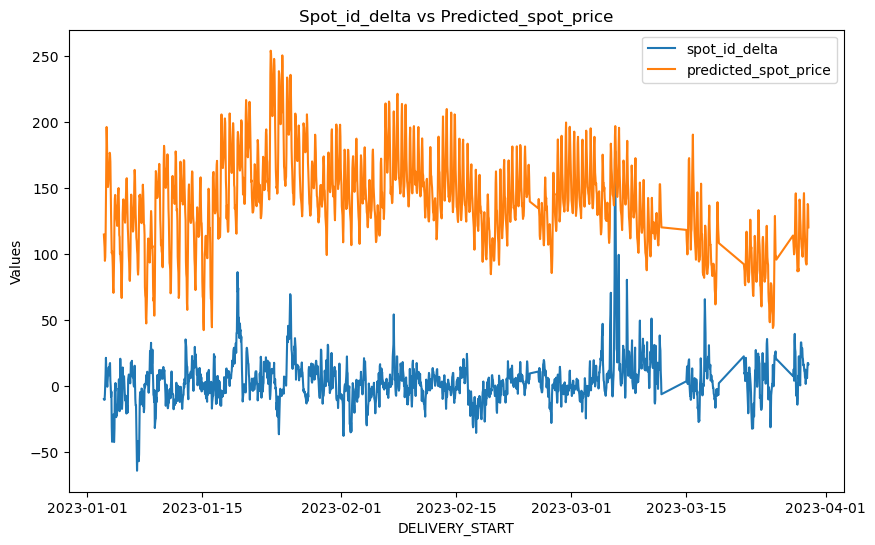

In [20]:

# 5) Affichage sur un même graphique des valeurs de y_clean et predicted_spot_price dans X_clean
plt.figure(figsize=(10, 6))
plt.plot(X_clean['DELIVERY_START'], y_clean['spot_id_delta'], label='spot_id_delta')
plt.plot(X_clean['DELIVERY_START'], X_clean['predicted_spot_price'], label='predicted_spot_price')
plt.xlabel('DELIVERY_START')
plt.ylabel('Values')
plt.title('Spot_id_delta vs Predicted_spot_price')
plt.legend()
plt.show()


In [21]:
# 6) Séparation des données en jeu d'entrainement et de test
X_clean = X_clean.dropna()
y_clean = pd.merge(X_clean[['DELIVERY_START']], y_clean, how='inner', on='DELIVERY_START')
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [22]:
print(X_clean.info(),
      y_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1822 entries, 8567 to 10604
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 1822 non-null   object 
 1   load_forecast                  1822 non-null   float64
 2   coal_power_available           1822 non-null   float64
 3   gas_power_available            1822 non-null   float64
 4   nucelear_power_available       1822 non-null   float64
 5   wind_power_forecasts_average   1822 non-null   float64
 6   solar_power_forecasts_average  1822 non-null   float64
 7   wind_power_forecasts_std       1822 non-null   float64
 8   solar_power_forecasts_std      1822 non-null   float64
 9   predicted_spot_price           1822 non-null   float64
dtypes: float64(9), object(1)
memory usage: 156.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 2 columns):
 #   Column   

In [24]:
X_mat_train = X_train_clean.drop(columns=['DELIVERY_START', 'predicted_spot_price']).values
X_mat_test = X_test_clean.drop(columns=['DELIVERY_START', 'predicted_spot_price']).values
# Calculer la somme de 'predicted_spot_price' de X et 'spot_id_delta' de Y
Z_train = (y_train_clean.groupby('DELIVERY_START')['spot_id_delta'].sum() + 
     X_train_clean.groupby('DELIVERY_START')['predicted_spot_price'].sum())
Z_train = Z_train.values

Z_test = (y_test_clean.groupby('DELIVERY_START')['spot_id_delta'].sum() + 
     X_test_clean.groupby('DELIVERY_START')['predicted_spot_price'].sum())
Z_test = Z_test.values

model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_mat_train, Z_train)

# Prédire sur l'ensemble de test
Z_pred = model.predict(X_mat_test)

# Évaluer le modèle
mse = mean_squared_error(Z_test, Z_pred)
r2 = r2_score(Z_test, Z_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", abs(r2))

# Afficher les coefficients du modèle
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error (MSE): 1575.8920894873859
R-squared (R2): 0.005086646973431641
Coefficients: [-1.47826354e-04 -1.27532564e-03  2.58031291e-03  1.69937592e-05
  3.20221046e-05 -3.89700412e-04 -6.40870120e-03  5.24441236e-02]
Intercept: 126.03644522294474


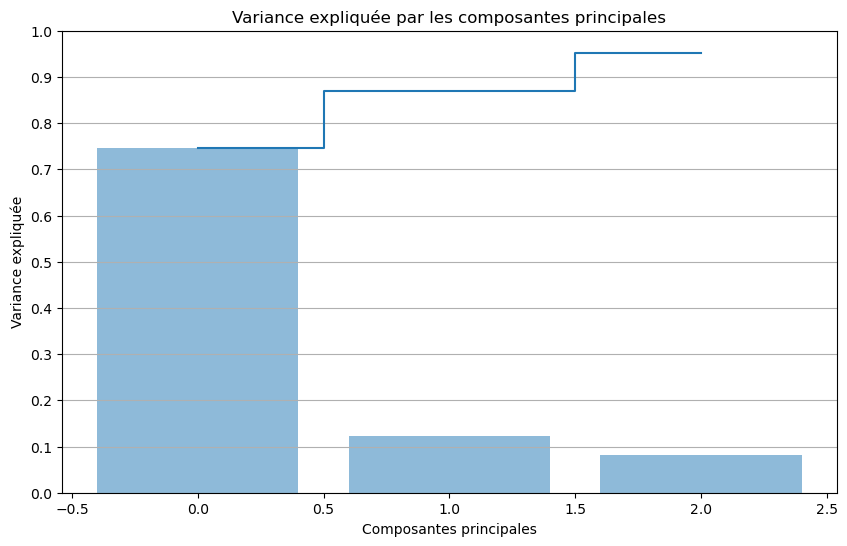

In [25]:
# 9) ACP
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train_clean.drop(columns=['DELIVERY_START']))

# Affichage des résultats de l'ACP
plt.figure(figsize=(10, 6))
plt.bar(range(n_components), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(n_components), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, axis='y') 
plt.show()



In [26]:
# ACP avec X_train avec imputation bayesian Ridge



In [27]:
Z_train_clean = (y_train_clean.groupby('DELIVERY_START')['spot_id_delta'].sum() + 
     X_train_clean.groupby('DELIVERY_START')['predicted_spot_price'].sum())
Z_train_clean = Z_train_clean.to_frame()
Z_train_clean = Z_train_clean.rename(columns={Z_train_clean.columns[0]: 'intraday'})
Z_train_clean = Z_train_clean['intraday'].values
len(Z_train_clean)

1457

In [28]:
def tendancy(Z):
    W = np.zeros_like(Z)
    for i in range(1,len(Z)):
        W[i] = np.sign(Z[i] - Z[i-1])
        if W[i] < 1 :
            W[i] += 1
    return W

W_train = tendancy(Z_train_clean)


In [29]:
def counter(W):
    c0, c1 = 0, 0
    for i in range(len(W)):
        if W[i] == 0 :
            c0 += 1
        else:
            c1 += 1
    return c0, c1

c0, c1 = counter(W_train)
print(" c0 : ", c0)
print(" c1 : ", c1)

 c0 :  815
 c1 :  642


In [30]:
# Initialiser les modèles
svm = SVC()
random_forest = RandomForestClassifier()
adaboost = AdaBoostClassifier()
xgboost = XGBClassifier()

# Initialiser le VotingClassifier
voting_clf = VotingClassifier(estimators=[('svm', svm), ('random_forest', random_forest), 
                                          ('adaboost', adaboost), ('xgboost', xgboost)], 
                              voting='hard')

# Entraîner les modèles
svm.fit(X_pca, W_train)
random_forest.fit(X_pca, W_train)
adaboost.fit(X_pca, W_train)
xgboost.fit(X_pca, W_train)
voting_clf.fit(X_pca, W_train)

models = {'SVM': svm, 'Random Forest': random_forest, 'AdaBoost': adaboost, 'XGBoost': xgboost, 'Voting Classifier': voting_clf}

for name, model in models.items():
    y_pred = model.predict(X_pca)
    accuracy = accuracy_score(W_train, y_pred)
    recall = recall_score(W_train, y_pred, average='macro')
    confusion = confusion_matrix(W_train, y_pred)
    print(f"Modèle: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Matrice de confusion:\n {confusion}")


Modèle: SVM
Accuracy: 0.5593685655456417
Recall: 0.5
Matrice de confusion:
 [[815   0]
 [642   0]]
Modèle: Random Forest
Accuracy: 1.0
Recall: 1.0
Matrice de confusion:
 [[815   0]
 [  0 642]]
Modèle: AdaBoost
Accuracy: 0.6183939601921757
Recall: 0.5906188483076276
Matrice de confusion:
 [[672 143]
 [413 229]]
Modèle: XGBoost
Accuracy: 0.9601921757035004
Recall: 0.9573084494390612
Matrice de confusion:
 [[800  15]
 [ 43 599]]
Modèle: Voting Classifier
Accuracy: 0.7144818119423473
Recall: 0.67601246105919
Matrice de confusion:
 [[815   0]
 [416 226]]


In [31]:
X_pca_test = pca.fit_transform(X_test_clean.drop(columns=['DELIVERY_START']))

Z_test_clean = (y_test_clean.groupby('DELIVERY_START')['spot_id_delta'].sum() + 
     X_test_clean.groupby('DELIVERY_START')['predicted_spot_price'].sum())
Z_test_clean = Z_test_clean.to_frame()
Z_test_clean = Z_test_clean.rename(columns={Z_test_clean.columns[0]: 'intraday'})
Z_test_clean = Z_test_clean['intraday'].values

W_test = tendancy(Z_test_clean)
c0, c1 = counter(W_test)
print(" c0 : ", c0)
print(" c1 : ", c1)

 c0 :  189
 c1 :  176


In [32]:
predictions = {}
for name, model in models.items():
    y_pred_test = model.predict(X_pca_test)
    predictions[name] = y_pred_test

# Comparer les prédictions avec W_test
for name, y_pred_test in predictions.items():
    accuracy = accuracy_score(W_test, y_pred_test)
    recall = recall_score(W_test, y_pred_test, average='macro')
    confusion = confusion_matrix(W_test, y_pred_test)
    print(f"Modèle: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Matrice de confusion:\n {confusion}")

Modèle: SVM
Accuracy: 0.5178082191780822
Recall: 0.5
Matrice de confusion:
 [[189   0]
 [176   0]]
Modèle: Random Forest
Accuracy: 0.5150684931506849
Recall: 0.5104467291967292
Matrice de confusion:
 [[121  68]
 [109  67]]
Modèle: AdaBoost
Accuracy: 0.5013698630136987
Recall: 0.4931156806156806
Matrice de confusion:
 [[137  52]
 [130  46]]
Modèle: XGBoost
Accuracy: 0.5643835616438356
Recall: 0.5611922799422799
Matrice de confusion:
 [[123  66]
 [ 93  83]]
Modèle: Voting Classifier
Accuracy: 0.5315068493150685
Recall: 0.5185034872534873
Matrice de confusion:
 [[167  22]
 [149  27]]


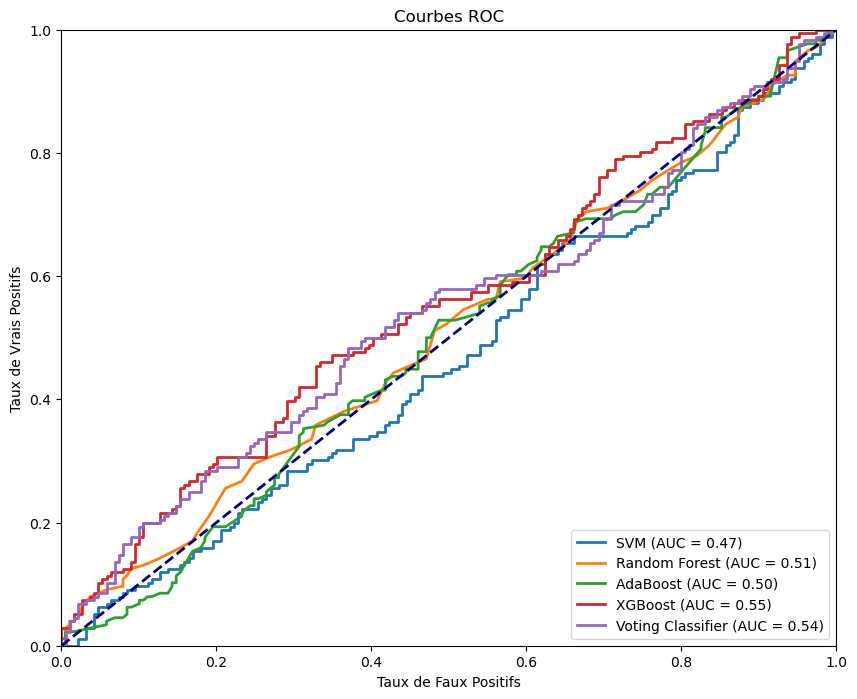

In [34]:
# 15) Courbes ROC
svm = SVC(probability=True)
random_forest = RandomForestClassifier()
adaboost = AdaBoostClassifier()
xgboost = XGBClassifier()

voting_clf = VotingClassifier(estimators=[
    ('svm', svm), 
    ('random_forest', random_forest), 
    ('adaboost', adaboost), 
    ('xgboost', xgboost)
], voting='soft')

models = {
    'SVM': svm, 
    'Random Forest': random_forest, 
    'AdaBoost': adaboost, 
    'XGBoost': xgboost, 
    'Voting Classifier': voting_clf
}

# Entraîner les modèles
for name, model in models.items():
    model.fit(X_pca, W_train)

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Prédire les probabilités pour le calcul de la courbe ROC
    y_prob_test = model.predict_proba(X_pca_test)[:, 1]

    # Calculer les taux de vrais positifs et de faux positifs
    fpr, tpr, _ = roc_curve(W_test, y_prob_test)

    # Calculer l'AUC
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Tracer la ligne diagonale pour une classification aléatoire
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()

On constate des comportements quasiment aléatoires très mal décrits par notre modèle intraday.

### Autre stratégie de traitement des données 

In [3]:
# Reprise des données initiales : on impute avec une nouvelle stratégie sur toutes les données manquantes 
imputer = SimpleImputer(strategy='mean')
bayesian_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, tol=1e-3, random_state=0)
X_train.iloc[:, 1:10] = bayesian_imputer.fit_transform(X_train.iloc[:, 1:10])
#X_train = X_train.drop(["predicted_spot_price"], axis=1)

# Constructions de quelques features supplémentaires
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True)

# Features temporelles
X_train['hour'] = X_train['DELIVERY_START'].dt.hour
X_train['day'] = X_train['DELIVERY_START'].dt.dayofweek
X_train['month'] = X_train['DELIVERY_START'].dt.month

# Features en absolue
X_train['total_power'] = (X_train['coal_power_available'] + 
                     X_train['gas_power_available'] + 
                     X_train['nucelear_power_available'])

X_train['total_renewable'] = (X_train['wind_power_forecasts_average'] + 
                         X_train['solar_power_forecasts_average'])

# Features de ratio
X_train['load_to_total_power_ratio'] = X_train['load_forecast'] / X_train['total_power']
X_train['renewable_to_nonrenewable_ratio'] = X_train['total_renewable'] / X_train['total_power']
    
    #rajouter des valeurs laggées genre 24 pour un jour avant

#X_train = X_train.drop(["predicted_spot_price"], axis=1)
X_train.set_index("DELIVERY_START", inplace=True)

print(X_train.isna().sum())

load_forecast                      0
coal_power_available               0
gas_power_available                0
nucelear_power_available           0
wind_power_forecasts_average       0
solar_power_forecasts_average      0
wind_power_forecasts_std           0
solar_power_forecasts_std          0
predicted_spot_price               0
hour                               0
day                                0
month                              0
total_power                        0
total_renewable                    0
load_to_total_power_ratio          0
renewable_to_nonrenewable_ratio    0
dtype: int64


In [4]:
# Scaling des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# On passe les valeurs de y en 0 ou 1 pour classifier en fonction du signe du delta
y_train['DELIVERY_START'] = pd.to_datetime(y_train["DELIVERY_START"], utc=True)
y_train.set_index("DELIVERY_START", inplace=True)
y_train["spot_id_delta"] = np.where(y_train["spot_id_delta"]>0, 1, 0)

In [10]:
# Séparation des sets 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.fit_transform(X_test2)

y_test3 = y_test2
# Formattage pour éviter les erreurs
y_train2 = np.ravel(y_train2)
y_test2 = np.ravel(y_test2)

In [88]:
# Réduction de dimensionalité spécifique aux time series : Functional PCA 

from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
fpca_discretized = FPCA(n_components=2)
fpca_discretized.fit(X_train2)
fpca_discretized.components_.plot()

AttributeError: X must be either FDataGrid or FDataBasis

### Sélection de modèle par Nested Cross-Validation

La nested CV permet d'avoir une boucle externe de k-fold cv pour diviser les données en ensemble de training et de test, et une boucle interne utilisée pour sélectionner le modèle en utilisant la validation croisée k-fold sur le set de training. Après la sélection du modèle, le set de test est utilisé pour évaluer les performances du modèle. Avec la nested CV, l'erreur réelle de l'estimation est presque sans biais par rapport à l'ensemble de données de test.

In [20]:
# Fonction pour réaliser une nested Cross-validation pour les différents modèles
def nested_cv(model, param_grid, X, y, n_iter=50, scoring='mcc', n_splits=5, random_state=1):
    scorer = make_scorer(matthews_corrcoef) if scoring == 'mcc' else make_scorer(scoring)
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    rs = RandomizedSearchCV(estimator=model,
                            param_distributions=param_grid,
                            scoring=scorer,
                            refit=True,
                            n_iter=n_iter,
                            cv=inner_cv,
                            random_state=random_state,
                            n_jobs=-1)
    
    rs.fit(X, y)
    print("Best parameters found: ", rs.best_params_)
    print("Best cross-validation score: ", rs.best_score_)
    
    nested_scores = cross_val_score(rs, X, y, scoring=scorer, cv=outer_cv, n_jobs=-1)
    print(f'Nested CV score: {np.mean(nested_scores):.3f} '
          f'+/- {np.std(nested_scores):.3f}')
    return rs, nested_scores

Scoring MCC mais d'autres peuvent être utilisés (f1, roc auc, rec, pre)

In [21]:
# Logistic Regression
log_reg = LogisticRegression(penalty='l2', random_state=1, solver='lbfgs')
log_reg_param_grid = {'C': np.linspace(0, 50, 200)}
best_log_reg, best_lr_scores = nested_cv(log_reg, log_reg_param_grid, X_train2_scaled, y_train2, n_iter=200)

Best parameters found:  {'C': 6.281407035175879}
Best cross-validation score:  0.051059129926750414
Nested CV score: 0.050 +/- 0.011


In [ ]:
# AdaBoost
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
ada_boost = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
ada_boost_param_grid = {'learning_rate': np.linspace(0.01, 1, 50)}
best_ada, best_ada_scores = nested_cv(ada_boost, ada_boost_param_grid, X_train2_scaled, y_train2, n_iter=50)

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=500, random_state=1)
rf_param_grid = {'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]}
best_rf, best_rf_scores = nested_cv(rf_clf, rf_param_grid, X_train2_scaled, y_train2, n_iter=12)

In [22]:
# XGBoost
xgb_clf = XGBClassifier(n_estimators=500, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_param_grid = {'max_depth': np.linspace(2, 50, 100, dtype=int), 'learning_rate': np.linspace(0.01, 1, 50)}
best_xgb, best_xgb_scores = nested_cv(xgb_clf, xgb_param_grid, X_train2_scaled, y_train2, n_iter=100, random_state=42)

Best parameters found:  {'max_depth': 48, 'learning_rate': 0.05040816326530612}
Best cross-validation score:  0.526659346384616


### Accuracy avec le test set

accuracy pour la régression logistique 0.5392834695160277
reccal pour la régression logistique 0.5394168603088791
Confusion Matrix:


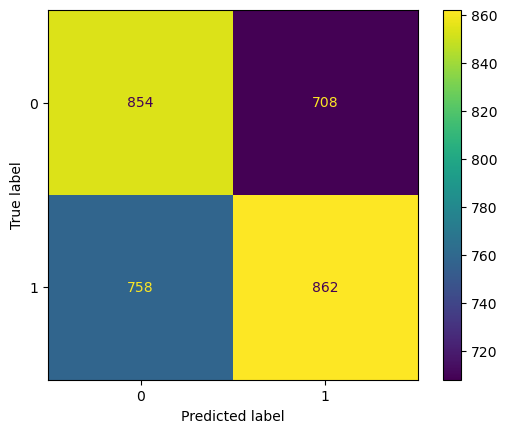

In [ ]:
# Prediction pour le modèle entrainé de la régression logistique
y_test_pred = best_log_reg.predict(X_test2_scaled)
print(f'accuracy pour la régression logistique {accuracy_score(y_test2, y_test_pred)}')
print(f'reccal pour la régression logistique {recall_score(y_test2, y_test_pred, average="macro")}')
print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=best_log_reg.classes_).plot()

In [ ]:
# Prediction pour le modèle entrainé Ada boost
y_test_pred = best_ada.predict(X_test2_scaled)
print(f'accuracy pour Ada boost {accuracy_score(y_test2, y_test_pred)}')
print(f'reccal pour Ada boost {recall_score(y_test2, y_test_pred, average="macro")}')
print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=best_ada.classes_).plot()

In [ ]:
# Prediction pour le modèle entrainé Random Forest
y_test_pred = best_rf.predict(X_test2_scaled)
print(f'accuracy pour Random Forest {accuracy_score(y_test2, y_test_pred)}')
print(f'reccal pour Random Forest {recall_score(y_test2, y_test_pred, average="macro")}')
print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=best_rf.classes_).plot()

accuracy pour le xgboost 0.7281583909490886
reccal pour le xgboost 0.7286009547746637
Confusion Matrix:


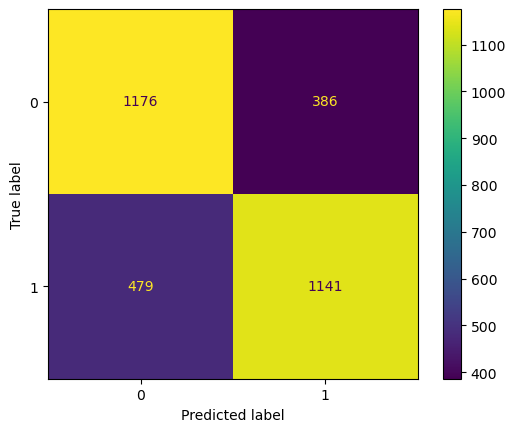

In [ ]:
# Prediction pour le modèle entrainé XGBoost
y_test_pred = best_xgb.predict(X_test2_scaled)
print(f'accuracy pour le xgboost {accuracy_score(y_test2, y_test_pred)}')
print(f'reccal pour le xgboost {recall_score(y_test2, y_test_pred, average="macro")}')
print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=best_xgb.classes_).plot()

## Courbes ROC

In [130]:
# Fonction de la courbe roc et 
%matplotlib inline

def roc_curve(classifier, cv, X, y, title='ROC Curve'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    y_real = []
    y_proba = []

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        precision, recall, _ = precision_recall_curve(y[test], probas_[:, 1])
        
        # Plotting each individual PR Curve
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y[test], probas_[:, 1])))
        
        y_real.append(y[test])
        y_proba.append(probas_[:, 1])

        i += 1
    
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [132]:
stratcv = StratifiedKFold(n_splits=5)
roc_curve(best_xgb, stratcv, X_test2_scaled, y_test2)

TypeError: roc_curve() missing 2 required positional arguments: 'X' and 'y'

### Interpretable ML

#### Méthode global : ALE

In [126]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3182 entries, 2022-01-13 17:00:00+00:00 to 2022-08-16 01:00:00+00:00
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   load_forecast                    3182 non-null   float64
 1   coal_power_available             3182 non-null   float64
 2   gas_power_available              3182 non-null   float64
 3   nucelear_power_available         3182 non-null   float64
 4   wind_power_forecasts_average     3182 non-null   float64
 5   solar_power_forecasts_average    3182 non-null   float64
 6   wind_power_forecasts_std         3182 non-null   float64
 7   solar_power_forecasts_std        3182 non-null   float64
 8   predicted_spot_price             3182 non-null   float64
 9   hour                             3182 non-null   int32  
 10  day                              3182 non-null   int32  
 11  month                            3

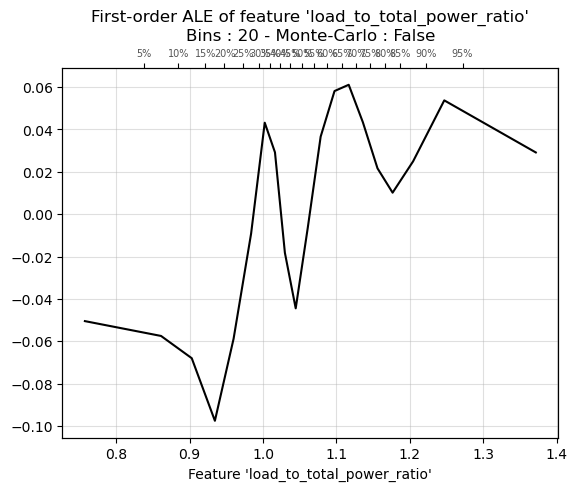

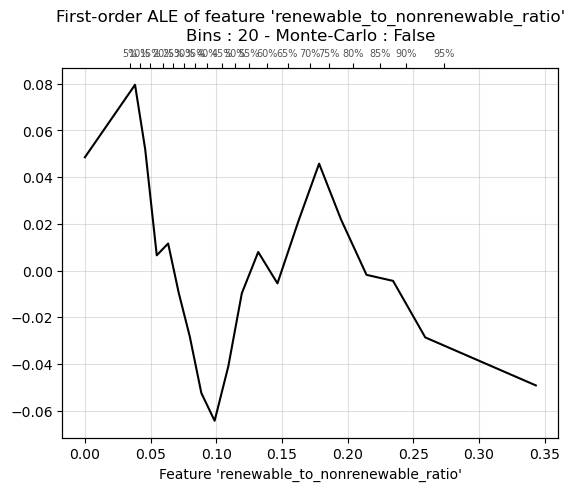

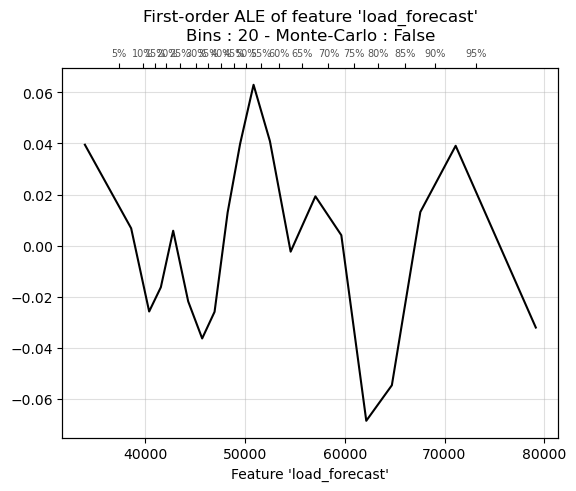

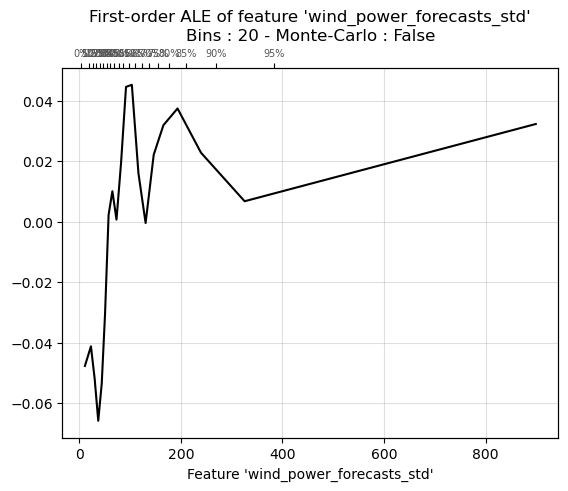

In [12]:
target_column = 'spot_id_delta'
X = X_test2[['load_to_total_power_ratio', 'renewable_to_nonrenewable_ratio', 'load_forecast', 'wind_power_forecasts_std']]
y = y_test3[target_column]

# Entraînement d'un modèle RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Colonnes pour lesquelles nous voulons interpréter les effets ALE
columns_to_interpret = [
    'load_to_total_power_ratio', 
    'renewable_to_nonrenewable_ratio', 
    'load_forecast', 
    'wind_power_forecasts_std'
]

# Générer les graphiques ALE pour chaque colonne
for column in columns_to_interpret:
    ale_plot(model, X, column, bins=20)
    plt.show()

In [ ]:
# pas finis donc run pas 
X_test_no_outliers = X_test2[
    (X_test2.year.quantile(.01) <= X_test.year) &\
    (X_test.year <= X_test.year.quantile(.99)) &\
    (X_test.odometer.quantile(.01) <= X_test.odometer) &\
    (X_test.odometer <= X_test.odometer.quantile(.99))
]
ale_effect = ale(
    X=X_test_no_outliers, model=cb_mdl, feature=['odometer'],\
    feature_type='continuous', grid_size=80
)
plt.show()
ale_effect = ale(
    X=X_test_no_outliers, model=cb_mdl,\
    feature=['make_cat_luxury'],feature_type='discrete'
)
plt.show()

#### Méthode locale : LIME

In [121]:
def lime_explanation(model, 
                     model_name, 
                     X_test, 
                     feature_names,  
                     class_names, 
                     instance_index, 
                     num_features=10,
                    categorical_features=None):
    
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_test.values,
        feature_names=feature_names,
        categorical_features=categorical_features,
        class_names=class_names,
        verbose=True,
        mode='classification'
    )

    exp = explainer.explain_instance(
        X_test.iloc[instance_index, :].values,
        model.predict_proba,
        num_features=num_features
    )
    
    print(f"Explanation for {model_name}:")
    exp.show_in_notebook(predict_proba=True)
    return exp


In [124]:
modeles = {
    'xgb': best_xgb,
    'svm': best_log_reg,
}

features = X_test2.columns
categorie = ['Not Highly Recomm.', 'Highly Recomm.']

index_valeur = 2000

for model_name, model in modeles.items():
    lime_explanation(model, model_name, X_test2, features, categorie, index_valeur)

Intercept 0.18062808906460592
Prediction_local [0.15926103]
Right: 0.16865626
Explanation for xgb:


Intercept 0.22368110048029144
Prediction_local [0.28207699]
Right: 0.0
Explanation for svm:
